### Appendix J: Generative Adversarial Networks (GAN)



In [1]:
!pip install tensorflow --quiet
!pip install imageio  --quiet
!pip install git+https://github.com/tensorflow/docs  --quiet

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

from IPython import display

In [6]:
IMAGE_DIR = './hw_images/characters'
INPUT_SHAPE = 28
BATCH_SIZE = 128


_, _, train_data_gen, _ = initialize_data_gen(IMAGE_DIR, INPUT_SHAPE, BATCH_SIZE)

Total number of images: 44074
Starting the data generation
Found 35259 validated image filenames.
Found 8815 validated image filenames.


In [11]:
def make_generator_model():
    model = tf.keras.Sequential(name='Generator')
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

#### Test the generation (untrained)

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

None


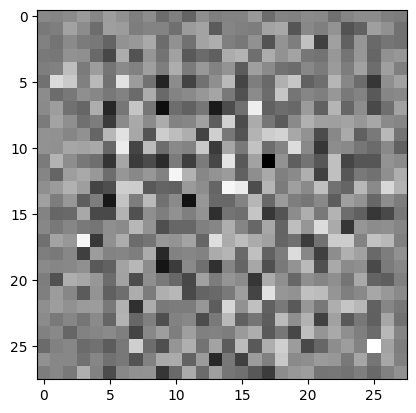

In [12]:
generator = make_generator_model()

print(generator.summary())

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### Discriminator model

In [14]:
def make_discriminator_model(INPUT_SHAPE):
    """

    Args:
      INPUT_SHAPE: The shape of the image

    Returns:
      model: the discriminator model
    """

    model = tf.keras.Sequential(name='Discriminator')
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[INPUT_SHAPE, INPUT_SHAPE, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

#### Test untrained discriminator model on image generated by untrained generator.

Positive values represent a real image while negative values represent fake images.

In [15]:
discriminator = make_discriminator_model(28)
print(discriminator.summary())
decision = discriminator(generated_image)
print (decision)

/Users/wisdom/Downloads/CS156 ML Assignment/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

None
tf.Tensor([[-3.0009654e-05]], shape=(1, 1), dtype=float32)


#### Loss functions and optimizers

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Training

In [19]:
from tqdm import tqdm

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# To start the generator model. Setting the seed allows us to see the GAN progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    """

    Args:
      images: the input images

    Returns:
      gen_loss: loss value of the generator model
      disc_loss: loss value of the discriminator model

    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    return gen_loss, disc_loss

def train(dataset, epochs):
  gen_losses = []
  disc_losses = []
  num_batches = len(dataset)
  print('Dataset length is:', len(dataset))

  for epoch in tqdm(range(epochs)):
    start = time.time()
    count = 0
    gen_loss_epoch = 0
    disc_loss_epoch = 0

    for i, image_batch in enumerate(dataset):
      image_batch = image_batch[0]

      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += gen_loss.numpy()
      disc_loss_epoch += disc_loss.numpy()

      if i % 50 == 1:
        print(f'Batch {i}, gen loss={gen_loss_epoch/i+1}, disc loss={disc_loss_epoch/i+1}')

      # We've gone through the dataset once
      if i == len(dataset)-1:
        break

    gen_losses.append(gen_loss_epoch/num_batches)
    disc_losses.append(disc_loss_epoch/num_batches)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print(f'Epoch {epoch + 1}, gen loss={gen_loss_epoch/num_batches}, disc loss={disc_loss_epoch/num_batches}')
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

  return gen_losses, disc_losses, list(range(epochs))

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

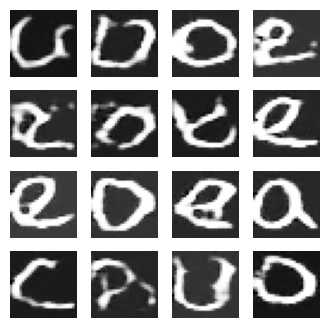

In [20]:
gen_losses, disc_losses, epoch_list = train(train_data_gen, EPOCHS)

#### Create GIF

In [21]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

/var/folders/1q/69ws035n1bbcn1pn2g3jj8rr0000gn/T/ipykernel_92500/4058920859.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/1q/69ws035n1bbcn1pn2g3jj8rr0000gn/T/ipykernel_92500/4058920859.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



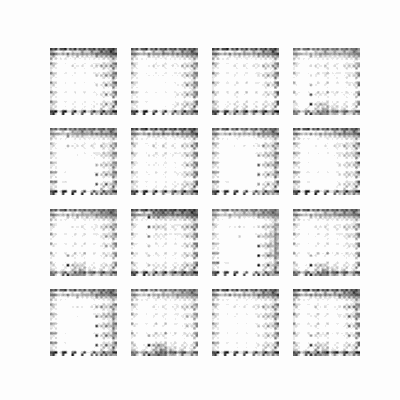

In [22]:
import tensorflow_docs.vis.embed as embed

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)


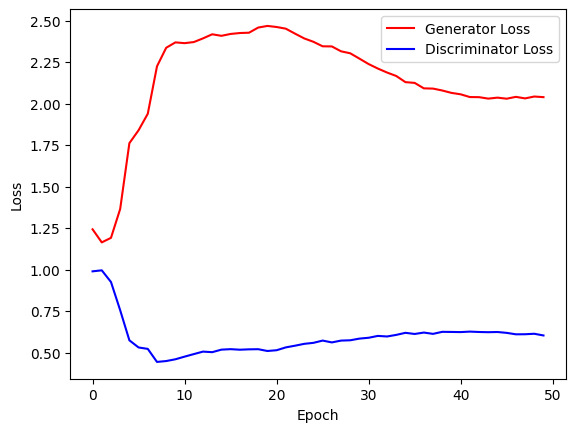

In [23]:
# Plot the generative model losses, discriminator model losses, and the epochs
plt.plot(epoch_list, gen_losses, label='Generator Loss', color='red')
plt.plot(epoch_list, disc_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()